# 4.- Euler-Maruyama class

In the previous notebook, we explained the essential concepts required to understand the Euler-Maruyama (EM) method. We also analysed the approximation error of the EM method with a basic example, which required the repetitive execution of a set of Python functions. To simplify this procedure, we can resort to a Python class. The aim of this notebook is to show a basic Python class implementation of the EM method. We will highlight the benefits that the object-oriented programming provides in terms of modularity and code reusability. Note that this notebook assumes a basic understanding of Python classess structure and functionality. However, we will emphasis some concepts like properties and inheritance. For a more in-depth review of Python classes, you can check the following course from the Research Computing & Data Science Skills Courses:
* https://github.com/ImperialCollegeLondon/python_oop_course

## Contents
### [A. The Euler-Maruyama class](#em-class)
### [B. The Coefficient class](#coefficient)

<a id="sde"></a>
### A. The Euler-Maruyama class

The EM class has been implemented in a separated file: `src/euler_maruyama/euler_maruyama.py`. First of all, we can import it to use in this notebook. The following code cells contain an example of how we may use this class to solve a EM problem. This demonstrates how to use the class.

In [36]:
import matplotlib.pyplot as plt

import sys
 
# we include outside folders in path
sys.path.append('..')

from src.euler_maruyama import EulerMaruyama

In [37]:
# Let us understand the content of the EulerMaruyama class using the help built-in function
help(EulerMaruyama)

Help on class EulerMaruyama in module src.euler_maruyama.euler_maruyama:

class EulerMaruyama(builtins.object)
 |  EulerMaruyama(t_0: float, t_n: float, n_steps: int, X_0: float, drift: src.euler_maruyama.coefficients.Coefficient, diffusion: src.euler_maruyama.coefficients.Coefficient, n_sim: int)
 |  
 |  Class to perform the numerical solution of a Stochastic Differential Equation (SDE) through the Euler-Maruyama method.
 |  
 |  Considering a SDE of the form: dX_t = mu(X_t, t)dt + sigma(X_t, t)dW_t, the solution of this SDE over
 |  the time interval [t_0, t_n] can be approximated as follows:
 |  
 |                  Y_{n+1} = Y_n + mu(Y_n, tau_n)(tau_{n+1} -  tau_n) + sigma(Y_n, tau_n)(W_{tau_{n+1}} - W_{tau_n})
 |  
 |  with initial condition Y_0 = X_0 and where the time interval is discretised:
 |  
 |                  t_0 = tau_0 < tau_1 <  ... < tau_n  = t_n
 |  
 |  with Delta_t = tau_{n+1} - tau_n = (t_n - t_0) / n and DeltaW_n = (W_{tau_{n+1}} - W_{tau_n}) ~ N(0, Delta_t)
 |

In [38]:
# Also import the drift and diffusion Coefficients
# We will discuss these coefficients in detail in section B

from src.euler_maruyama import ConstantDiffusion, LinearDrift

linear_drift = LinearDrift(a=1)  # drift (mu) = 1*t
constant_diffusion = ConstantDiffusion(b=2.5)  # diffusion (sigma) = 2.5 

We initialise an instance of the EulerMaruyama class calling the class constructor defined by the `__init__` method. In this constructor, we pass the basic parameters required to solve an Stochastic Differential Equation (SDE), namely the time interval, the number of time steps, the inital value, the drift and diffusion coefficients and the number of random trajectories to compute.

In [39]:
em = EulerMaruyama(t_0=0, t_n=2, n_steps=100, X_0=1, drift=linear_drift, diffusion=constant_diffusion, n_sim=1_000)

Now the variable `em` contains an instance of the `EulerMaruyama` class. We can access the attributes and methods of the class by referring them to using the `em.` syntax. For example, the `compute_numerical_approximation` method calculates the numerical approximation based on the principles explained in notebook 3.- Euler-Maruyama method. Such calculation is done within the `_solve_numerical_approximation`. The reson to encapsulate the logic in this way will be commented in the following notebook. Now, we can assume that `compute_numerical_approximation` and `_solve_numerical_approximation` are identical. Within the class, the numerical approximation is encapsualted into a method that updates internally the values of the attribute Y at each time step. The update process at each time step is done simultaneously for all random trajectories  using numpy vectorisation. Note that at each time step, the method obtains the drift ($\mu$) and diffusion ($\sigma$) values calling the `get_value` method of the `_drift` and `_diffusion` attributes. We will explain this implementation in the following section. The `compute_numerical_approximation` method also returns the array `Y` attribute for those users who want to further analyse. 

In [40]:
help(em.compute_numerical_approximation)

Help on method compute_numerical_approximation in module src.euler_maruyama.euler_maruyama:

compute_numerical_approximation() -> numpy.ndarray method of src.euler_maruyama.euler_maruyama.EulerMaruyama instance
    Compute the EM approximation for all simulated trajectories.
    
    Returns
    -------
    Y: np.ndarray
        Array containing the approximated solution of the SDE, shape(n_sim, n_steps+1).



In [41]:
Y = em.compute_numerical_approximation()

We then can plot the result of the numerical solution by calling the `plot_approximation` method. We can also access the values of the number of steps and time step length by calling the attributes `em.n_steps` and `em.delta`. We will discuss the specific implementation of `n_steps` later.

In [42]:
help(em.plot_approximation)

Help on method plot_approximation in module src.euler_maruyama.euler_maruyama:

plot_approximation(title: str) -> None method of src.euler_maruyama.euler_maruyama.EulerMaruyama instance
    Plot the numerical approximation obtained for the SDE.
    
    Parameters
    ----------
    title: str
        Title of the figure.



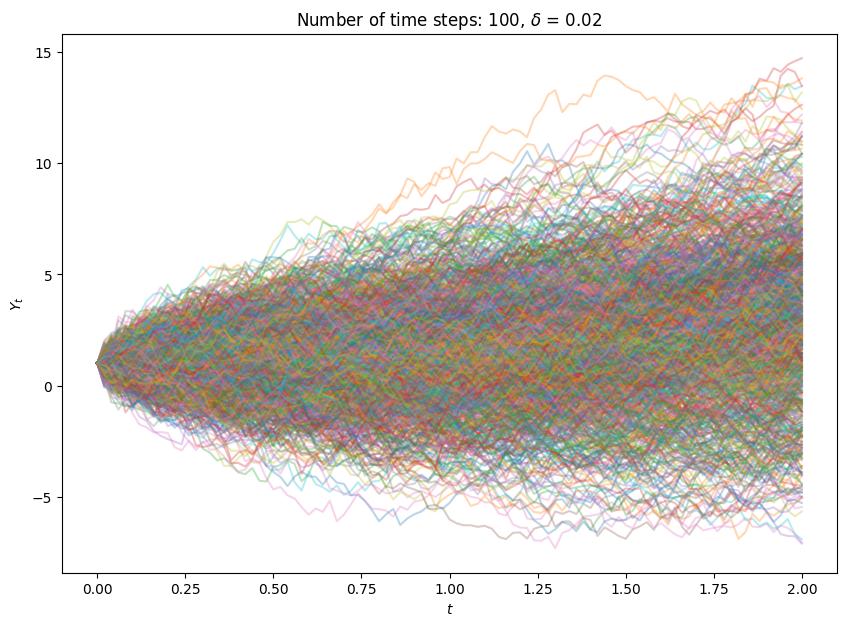

In [43]:
title=f"Number of time steps: {em.n_steps}, $\delta$ = {em.delta}"
em.plot_approximation(title=title)

This is really useful. By encapsulating the logic of the EM method within the class, we can efficiently solve the SDE. Additionaly, the class provides seamless analysis of the obtained solution when modifying the parameters of the EM method. Indeed, let us analyse how we can change two essential parameters of the EM method, namely the `n_sim` and `n_steps`.

First, let us examine `n_sim`. In the EM class, this attribute is implemented as a property. In object-oriented programming, and specifically in Python classes, a property is a special pattern that enables controlled access to class attributes. The property combines the behavior of a getter and setter method, allowing us to define custom logic for getting and setting attribute values. Properties encapsulates the internal representation of an attribute while providing a clean and controlled interface for accessing and modifying its value. 

Note, that `n_sim` property has the following methods:

```
@property
def n_sim(self):
    return self._n_sim

@n_sim.setter
def n_sim(self, value: int):
    """ Change the number of simulations.

    Parameters
    ----------
    value: int
        Number of simulations.
    """
    if value > 0:
        self._n_sim = value
    else:
        raise ValueError("Number of simulations must be positive.")
```

The `@property` decorator establishes the getter method, which returns the class attribute `_n_sim` which stores the number of simulations value. Conversely, the `@n_sim.setter` decorator implements the setter method, assigning the value of the internal class attribute `_n_sim`. To protect from unintended behaviour of the EM class, this setter checks whether the pass value is a negative number by raising a `ValueError`. Let us check this functionality.

In [44]:
print("Number of simulations: ", em.n_sim)

Number of simulations:  1000


In [45]:
# Change the number of simulations
em.n_sim = 1

print("Number of simulations: ", em.n_sim)

em.n_sim = 1_000

print("Number of simulations: ", em.n_sim)

Number of simulations:  1
Number of simulations:  1000


In [46]:
# Attempt a negative value
em.n_sim = -10

ValueError: Number of simulations must be positive.

Now, let us check the `n_steps` property:

```
    @property
    def n_steps(self):
        return self._n_steps

    @n_steps.setter
    def n_steps(self, value: int):
        """Change the number of time steps attribute and recalculate the discretisation.

        Parameters
        ----------
        value: int
            Number of time steps.
        """
        if value > 0:
            self._n_steps = value
            self._compute_discretisation()
        else:
            raise ValueError("Number of steps must be positive.")
```

This property follows a similar structure to `n_sim`. However, when the `_n_steps` value is modified in the setter methods, the time discretisation must be updated. This is precisely included in the setter method, by calling to the `_compute_discretisation` method. Let us change the n_steps to see how the EM solution change.

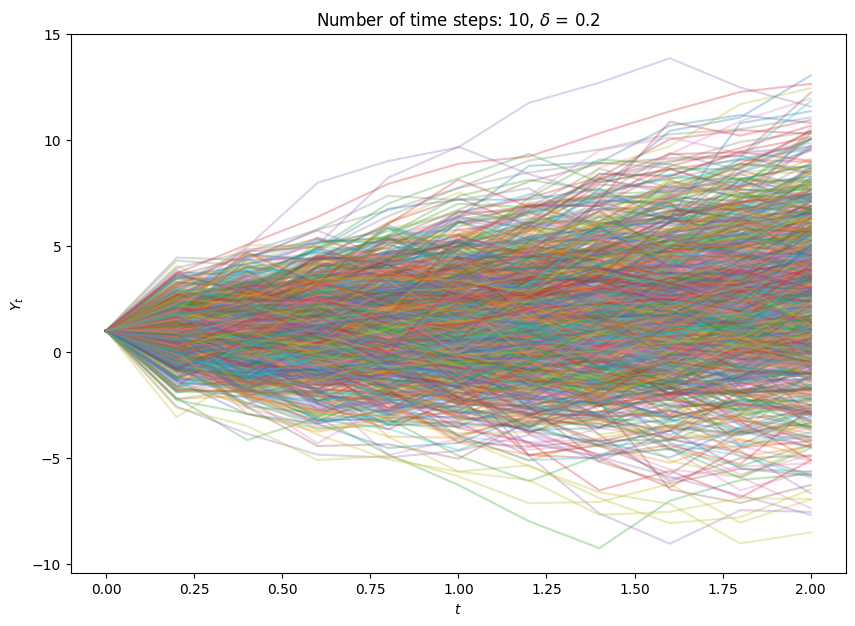

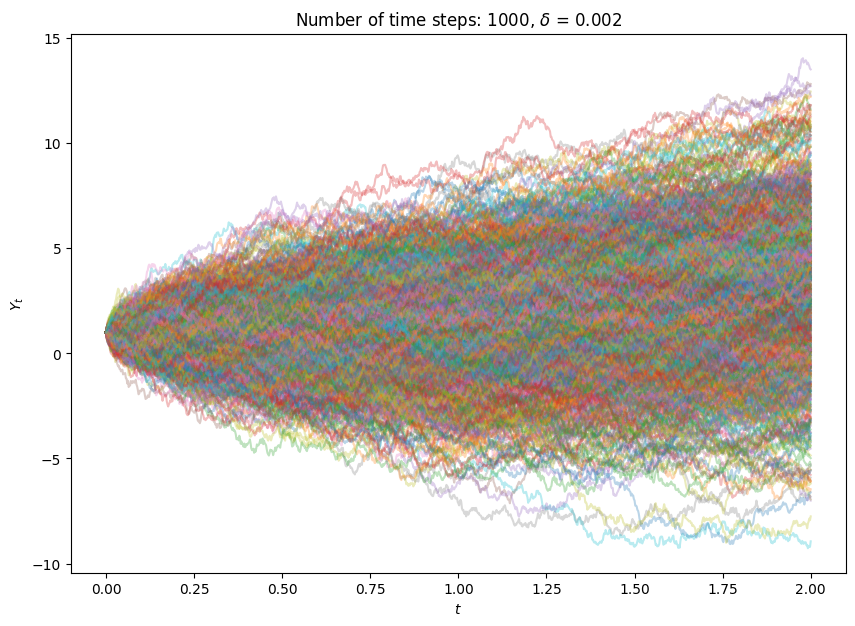

In [47]:
# We can see how easy is to change parameters thanks to the class __init__ method
em.n_steps = 10
Y = em.compute_numerical_approximation()
title=f"Number of time steps: {em.n_steps}, $\delta$ = {em.delta}"
em.plot_approximation(title=title)

em.n_steps = 1000
Y = em.compute_numerical_approximation()
title=f"Number of time steps: {em.n_steps}, $\delta$ = {em.delta}"
em.plot_approximation(title=title)

<a id="coefficient"></a>
### B. The Coefficient class

So far, we have seen the advantages of using the `EulerMaruyama` class for our project. However, to see more capabiliites of the `EulerMaruyama` class, we would like to test different drift and diffusion coefficients. By doing so, we can achieve code modularity and reusability, allowing the EulerMaruyama class to serve as a versatile numerical implementation for solving user-defined SDE. Specifically, the `EulerMaruyama` class includes a method called `compute_numerical_approximation` to solve the numerical approximation of the SDE. To obtain such numerical approximation, the method computes the drift and diffusion values at each time step. Typically, the drift and diffusion values are functions of the process value $X_t$ and the time step $t$. Hence, we could envisage a pattern where the computation of the drift and diffusion value shares a common structure. To accomplish this, we introduce another Python class, the `Coefficient` class, which replicates such desired functionality. The aim of the `Coefficient` class is to serve as a template that shares common directives and guarantees specific methods that can be embedded in the `EulerMaruyama` class. Based on this new class, we introduce two new concepts: class inheritance and abstract classes.

**Class inheritance** is a fundamental feature in object-oriented programming where a class can inherit properties and methods from another parent class, called the base class. The subclass or child class copies by default the attributes and methods of the superclass. This inheritance fosters code reuse, organization and modularity. This hierarchical relationship enables the subclass to extend or modify the functionality of the superclass, facilitating the creation of specialized classes while maintaining a cohesive code structure.

On the other hand, an **abstract class** is a class that cannot be instantiated directly. It serves as a template for other classes, defining common attributes and methods that derived classes should implement. Abstract classes often contain abstract methods, which are declared but have no implementation in the abstract class itself. Classes that inherint from an abstract class must provide concrete implementations for the abstract methods. The abstract class pattern is useful for creating a common interface and enforcing a specific structure among related classes.

To define an abstract class all we have to do is:

```
from abc import ABC, abstractmethod

class Coefficient(ABC):
```

This makes `Coefficient` class an abstract class. Now we can define some abstract methods within it. Particularly, we would like to implement a `get_value` method to compute the drift and diffusion coefficients at any particular time step. Within the `EulerMaruyama` class, the method `_solve_numerical_approximation` will call `get_value` of each coefficient at every time step. Therefore, it is essential that all drift and diffusion coefficients must implement this `get_value` method to guarantee the integration between the `EulerMaruyama` and `Coefficient` classes. By defining an astract method, this integration is achieved. The abstract method implementation allows for easy definition of various drift and diffusion coefficient types, ensuring compatibility with the `EulerMaruyama` class. To define an abstract method we utilise the `@abstractmethod` decorator, as shown here:

```
class Coefficient(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def get_value(self, X: np.ndarray, t: float) -> np.ndarray:
        raise NotImplementedError
        
    def plot_X_sample(self):
        # some code...
        
    def plot_t_sample(self):
        # some code...
```
Note that `plot_X_sample` and `plot_t_sample` are not abstract methods. This means they have their own implementation and functionality purpose. For our purpose, every drift and diffusion class must be implemented as a child class of `Coefficient` class. To indicate that a class inherints from a parent class, we simply write:

```
class LinearDrift(Coefficient):
```

This means that the `LinearDrift` class is derived from the `Coefficient` class, copying existing attributes and methods by default, such as `plot_X_sample` and `plot_t_sample` methods. Note that in this particular case, since `Coefficient` is an abstract class, it enforces `LinearDrift` to define a specific `get_value` implementation. 

Throguh this abstract-inheritance functionality, we can define different types of drift and diffusion forms. Then, in the `compute_numerical_approximation` and `_solve_numerical_approximation` method of the `EulerMaruyama` class, the drift ($\mu$) and diffusion ($\sigma$) values require, at least, the process value $X_t$ and the time step $t$ to compute their values. This the reason of implementing both the `_drift` and `_diffusion` attributes as `Coefficient` objects, which must have the `get_value` method implemented.

Let us import the Coefficient and some of the drift and diffusion functions defined to see that all classes have the `get_value`, `plot_X_sample` and `plot_t_sample` methods.

In [48]:
from src.euler_maruyama.coefficients import Coefficient

In [49]:
help(Coefficient)

Help on class Coefficient in module src.euler_maruyama.coefficients:

class Coefficient(abc.ABC)
 |  Abstract class to define the internal structure of the drift and diffusion coefficients.
 |  
 |  Methods
 |  -------
 |  get_value
 |  plot_X_sample
 |  plot_t_sample
 |  
 |  Method resolution order:
 |      Coefficient
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_value(self, X: numpy.ndarray, t: float) -> numpy.ndarray
 |  
 |  plot_X_sample(self) -> None
 |      Plot the coefficient value for 100 samples of X between 0 and 10.
 |  
 |  plot_t_sample(self) -> None
 |      Plot the coefficient value for 100 samples of t between 0 and 1.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      lis

We define a `LinearDrift` class as follows:

```
class LinearDrift(Coefficient):
    def __init__(self, a: float):
        super().__init__()
        self.a = a

    def get_value(self, X: np.ndarray, t: float) -> np.ndarray:
        return np.ones_like(X) * self.a*t
```

Note that in this case, $a*t$ is a scalar but we are solving simultaneosuly the EM method for an ensemble of `n_sim` simulations. By using numpy vectorisation, we can multiply the scalar $a*t$ by `np.ones_like(X)` to match the required number of dimensions.

We import the class to check its documentation. Note that the `plot_X_sample` and `plot_t_sample` methods appears like inherited from the `Coefficient` class. 

In [50]:
from src.euler_maruyama import LinearDrift
help(LinearDrift)

Help on class LinearDrift in module src.euler_maruyama.coefficients:

class LinearDrift(Coefficient)
 |  LinearDrift(a: float)
 |  
 |  Implement a linear drift of the form:
 |  
 |                      mu(X_t, t) = a*t
 |  
 |  where a is a real value parameter.
 |  
 |  Parameters
 |  ---------
 |  a: float
 |      The linear coefficient of drift
 |  
 |  Methods
 |  -------
 |  get_value
 |  
 |  Method resolution order:
 |      LinearDrift
 |      Coefficient
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, a: float)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_value(self, X: numpy.ndarray, t: float) -> numpy.ndarray
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __abstractmethods__ = frozenset()
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Coefficient:

Similarly, we can define a `ConstantDiffusion` as follows:

```
class ConstantDiffusion(Coefficient):
    def __init__(self, b: float):
        super().__init__()
        self.b = b

    def get_value(self, X: np.ndarray, t: float) -> np.ndarray:
        return np.ones_like(X) * self.b
```
and we import it to check its documentation.

In [51]:
from src.euler_maruyama import ConstantDiffusion
help(ConstantDiffusion)

Help on class ConstantDiffusion in module src.euler_maruyama.coefficients:

class ConstantDiffusion(Coefficient)
 |  ConstantDiffusion(b: float)
 |  
 |  Implement a constant diffusion of the form:
 |  
 |                      sigma(X_t, t) = b
 |  
 |  where b is a real value parameter.
 |  
 |  Parameters
 |  ---------
 |  b: float
 |      The constant diffusion value.
 |  
 |  Methods
 |  -------
 |  get_value
 |  
 |  Method resolution order:
 |      ConstantDiffusion
 |      Coefficient
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, b: float)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_value(self, X: numpy.ndarray, t: float) -> numpy.ndarray
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __abstractmethods__ = frozenset()
 |  
 |  ----------------------------------------------------------------------
 |  Method

Now, let us see how the `EulerMaruyama` class allows us to seamlessly validate different drift and diffusion implementations.

In [52]:
linear_drift = LinearDrift(a=1)  # drift (mu) = 1*t
constant_diffusion = ConstantDiffusion(b=2.5)  # diffusion (sigma) = 2.5 

We can check the `plot_X_sample` and `plot_t_sample` methods. Recall that their implementation is carried out in `Coefficient` class. Hence, any child class derived from `Coefficient` class will have these methods. In terms of their core functionality, these methods generate plots showcasing samples of the coefficient values for various `X` or `t` values within a small interval. It's worth noting that this method calls the get_value method of the respective class itself, which will exhibit distinct logic depending on the specific coefficient being used.

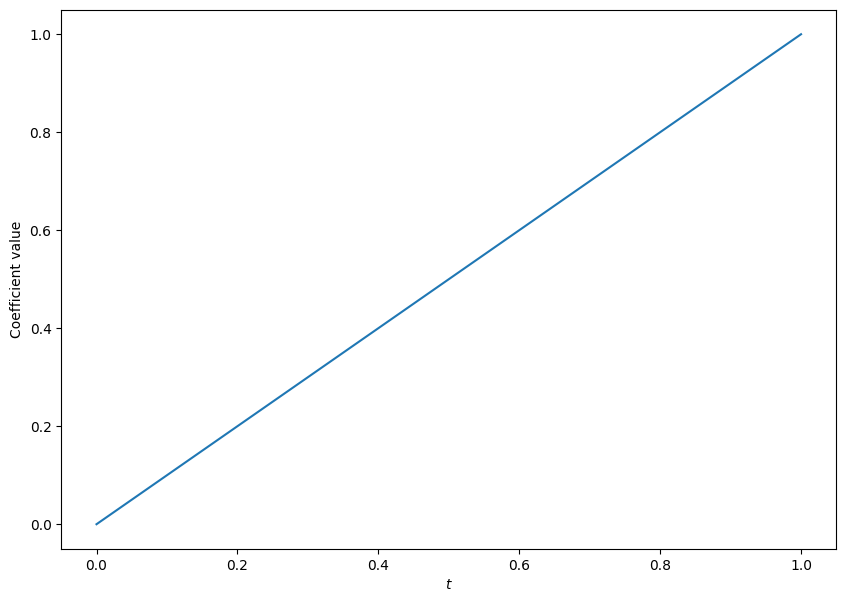

In [53]:
# We check the plot_X_sample and plot_t_sample methods
linear_drift.plot_t_sample()

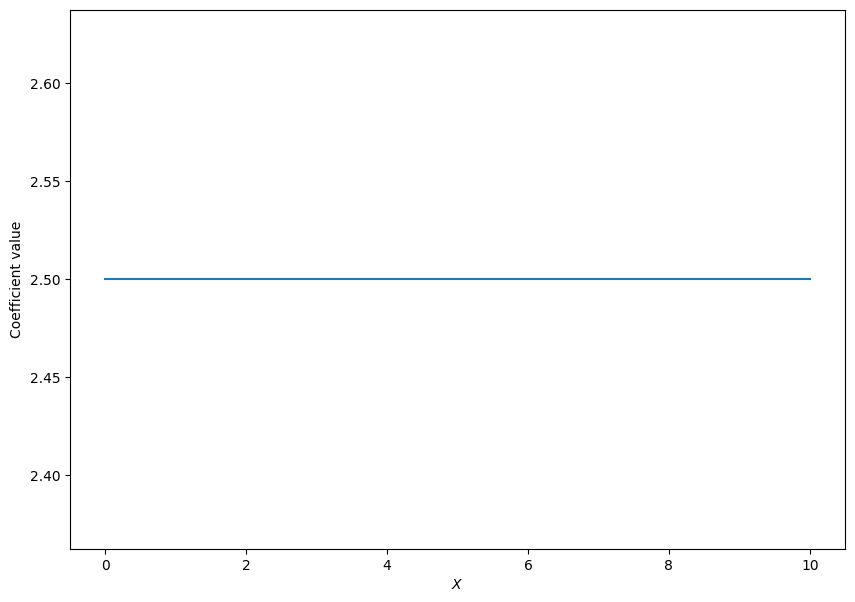

In [54]:
constant_diffusion.plot_X_sample()

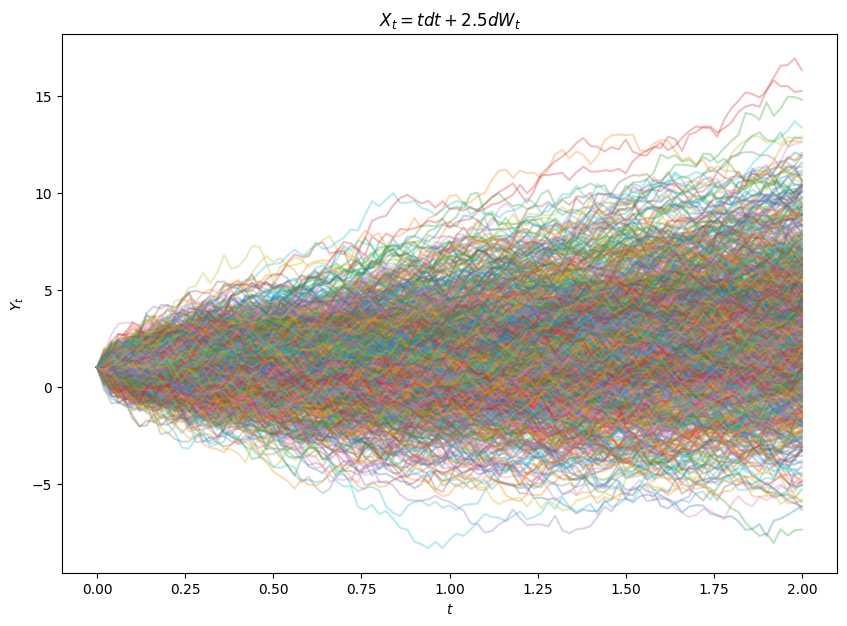

In [55]:
em = EulerMaruyama(t_0=0, t_n=2, n_steps=100, X_0=1, drift=linear_drift, diffusion=constant_diffusion, n_sim=1_000)
Y = em.compute_numerical_approximation()

title=r"$X_t = tdt + 2.5dW_t$"
em.plot_approximation(title=title)

Now, we can replace the linear drift of the form $\mu(X_t, t) = t$ by a mean-reversion drift $\mu(X_t, t) = \theta(\nu-X_t)$, where $\theta$ is the speed of reversion and $\nu$ is the equilibrium or mean parameter. We define a new `MeanReversionDrift` class that inherints from the abstract `Coefficient` class:

```
class MeanReversionDrift(Coefficient):
    def __init__(self, theta: float, mean: float):
        super().__init__()
        self.theta = theta
        self.mean = mean

    def get_value(self, X: np.ndarray, t: float) -> np.ndarray:
        return self.theta * (self.mean - X)
```

In [56]:
# Let us change the drift coefficient
from src.euler_maruyama import MeanReversionDrift

mean_reversion_drift = MeanReversionDrift(theta=4, mean=8)  # drift (mu) = 4*(8-X_t)

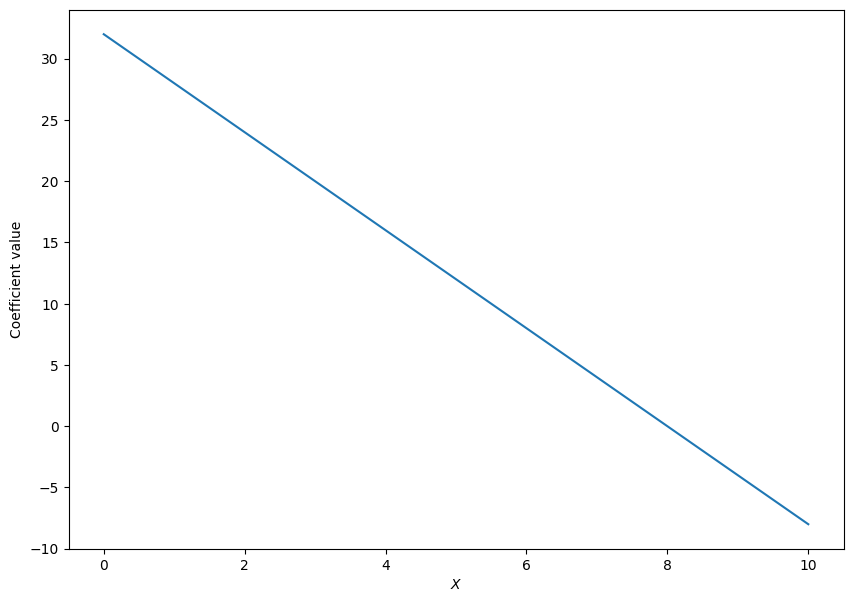

In [57]:
# Check the plot_X_sample
mean_reversion_drift.plot_X_sample()

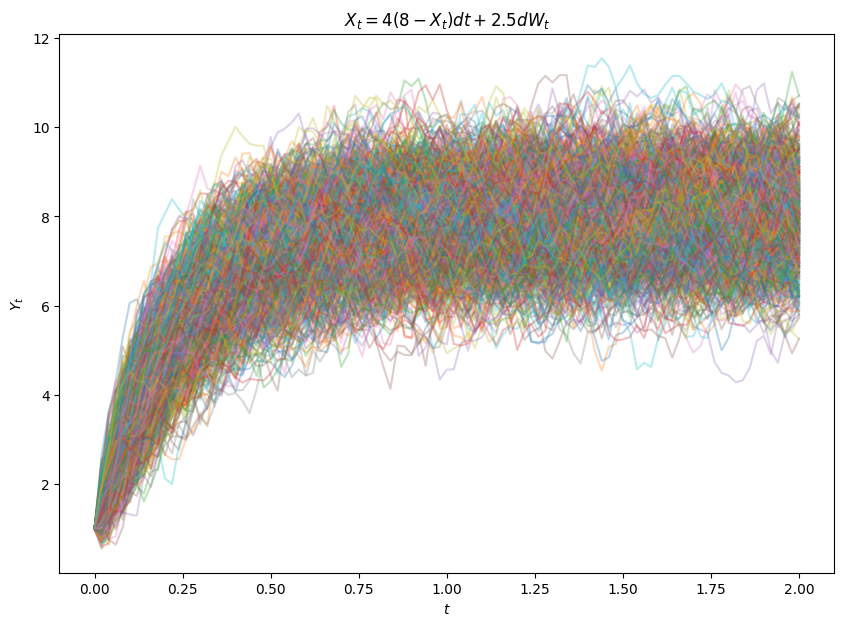

In [58]:
em._drift = mean_reversion_drift  # we replace the _drift attribute

Y = em.compute_numerical_approximation()

title=r"$X_t = 4(8-X_t)dt + 2.5dW_t$"
em.plot_approximation(title=title)

For the sake of clarity, we provide a mathematical intuition of what is happening in this process, although it is not necesary to understand the `Coefficient` implementation.

Given that the initial value of the defined SDE is $X_0=1$, and the equilibrium value of the mean-reverting process is $8$, the drfit in the inital steps exhibit a substantial drift compared to the random noise introduced by the Brownian motion. During these early time steps, the drift dominates the dynamics of the process $X_t$. Once the process $X_t$ approaches the vicinity of the equilibrium value, around $t \approx 0.75$, the diffusion becomes the prevailing factor, as the drift is almost negligible.

Additionally, we have implemented a MultiplicativeNoiseDiffusion class, following the same underlying principles as the other coefficients. You have the flexibility to experiment with the provided coefficients or try implementing your own drift or diffusion functionality.